In [1]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import keras
import ast
from glob import glob
from dask import bag
import os
from keras import Model, Sequential, optimizers
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
from io import BytesIO
%matplotlib inline

Using TensorFlow backend.


In [165]:
from random import shuffle
fnames = glob('input/train_simplified/*.csv')
shuffle(fnames)
fnames = fnames[0:20]
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:10]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[147, 87, 88, 43, 22, 8, 2, 0, 23, 27, 38, 5...",4661371469824000,True,2017-01-31 18:57:18.744830,sweater
1,US,"[[[80, 86, 97, 134, 160, 178, 179, 227, 255, 2...",6223683888611328,True,2017-03-23 20:53:23.337530,sweater
2,US,"[[[0, 23, 37, 51, 93, 122, 154, 163, 218, 239,...",6070764249808896,True,2017-01-27 18:23:51.389140,river
3,AU,"[[[170, 172, 0, 8, 16, 11], [4, 7, 9, 19, 23, ...",6199475305447424,True,2017-03-24 21:00:26.802270,river
4,US,"[[[0, 43, 86, 142, 209, 253], [131, 128, 130, ...",4633601083703296,True,2017-01-25 21:04:42.558000,shoe
5,US,"[[[16, 6, 5, 13, 22, 36, 57, 124, 156, 172, 18...",6341790003101696,True,2017-03-03 14:49:30.951550,shoe
6,US,"[[[4, 18, 29, 63, 93, 120, 146, 169, 186, 218,...",5837948178137088,True,2017-03-28 18:21:01.239740,banana
7,GB,"[[[189, 211, 223, 224, 217, 219, 207, 169, 126...",4950117624840192,True,2017-01-25 14:28:31.461580,banana
8,US,"[[[41, 43, 125, 172, 245, 244, 255, 249, 245, ...",5047489159757824,True,2017-03-09 15:55:54.953920,table
9,GB,"[[[67, 68, 74], [138, 56, 44]], [[157, 153, 15...",6514828547981312,True,2017-03-19 13:47:04.609940,table


In [166]:
evens = range(0,48,2)
odds = range(1,47, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

example1s
example2s

[[[[80,
    86,
    97,
    134,
    160,
    178,
    179,
    227,
    255,
    213,
    185,
    164,
    178,
    179,
    175,
    133,
    63,
    43,
    72,
    35,
    1,
    5,
    0,
    73],
   [11,
    18,
    21,
    23,
    12,
    0,
    7,
    78,
    112,
    140,
    119,
    95,
    183,
    204,
    210,
    212,
    221,
    220,
    76,
    96,
    107,
    85,
    53,
    13]],
  [[88, 124, 174], [9, 13, 1]]],
 [[[170, 172, 0, 8, 16, 11], [4, 7, 9, 19, 23, 21]],
  [[171, 4, 13], [4, 3, 6]],
  [[182, 194, 211, 230, 241, 255], [5, 12, 14, 1, 0, 10]]],
 [[[16,
    6,
    5,
    13,
    22,
    36,
    57,
    124,
    156,
    172,
    180,
    192,
    211,
    251,
    255,
    250,
    245,
    109,
    18,
    2,
    1,
    22,
    65,
    148,
    243,
    250,
    253,
    253,
    246],
   [82,
    76,
    58,
    41,
    32,
    29,
    30,
    43,
    44,
    37,
    28,
    0,
    11,
    12,
    15,
    84,
    97,
    88,
    75,
    80,
    87,
    98,

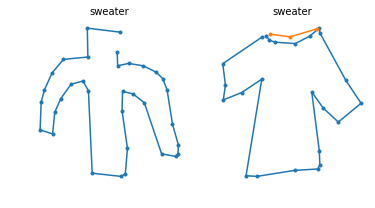

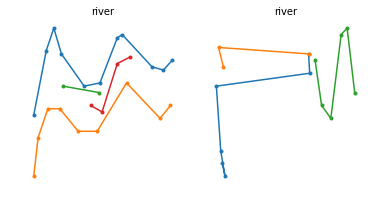

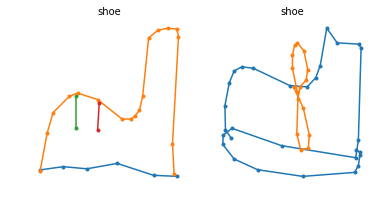

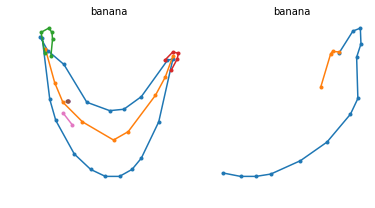

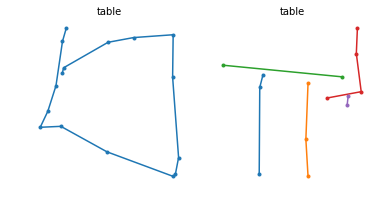

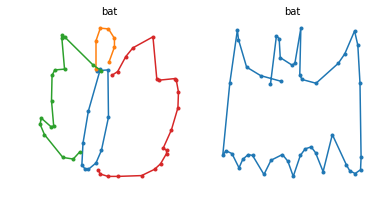

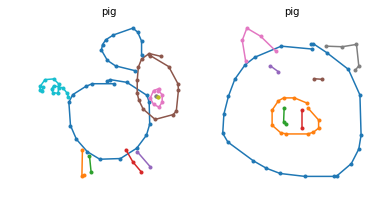

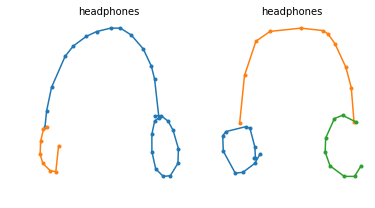

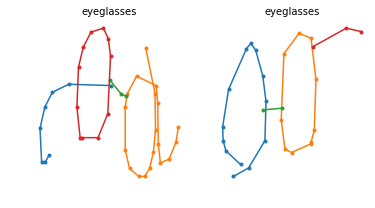

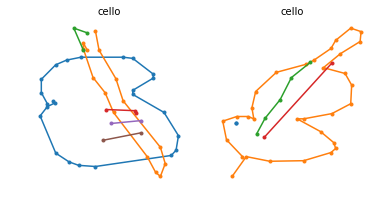

In [167]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)
    plt.gca().invert_yaxis()
    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)
    plt.gca().invert_yaxis()
    plt.show()

In [168]:
#%% set global vars and params
class_files = fnames
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(class_files)}

class_fraction = 1                     ## 
imheight, imwidth = 32, 32  
ims_per_class = 2000 

num_classes = int(len(class_files)*class_fraction)
num_classes 

20

In [169]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
train_grand = []
class_paths = fnames
for i,c in enumerate(class_paths[0: num_classes]):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

In [170]:
train_grand.shape

(40000, 1025)

In [171]:
# memory-friendly alternative to train_test_split?
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)


(36000, 20) 
 (36000, 32, 32, 1) 
 (4000, 20) 
 (4000, 32, 32, 1)


In [172]:
#input_shape = X_tr[0].shape

# Modify model layers to increase accuracy
# ------------------------------------------------
# Model 1
# ------------------------------------------------

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 680)               2785960   
__________

In [173]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()
callbacks = [history_cb]

In [174]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

In [175]:
tf.global_variables_initializer()
model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 5,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Train on 36000 samples, validate on 4000 samples
Epoch 1/5
36000/36000 [==============================] - 134s 4ms/step - loss: 1.3452 - acc: 0.5849 - top_3_accuracy: 0.7985 - val_loss: 0.6465 - val_acc: 0.8065 - val_top_3_accuracy: 0.9430
Epoch 2/5
36000/36000 [==============================] - 130s 4ms/step - loss: 0.7196 - acc: 0.7777 - top_3_accuracy: 0.9348 - val_loss: 0.5519 - val_acc: 0.8365 - val_top_3_accuracy: 0.9520
Epoch 3/5
36000/36000 [==============================] - 132s 4ms/step - loss: 0.5753 - acc: 0.8204 - top_3_accuracy: 0.9536 - val_loss: 0.4482 - val_acc: 0.8648 - val_top_3_accuracy: 0.9647
Epoch 4/5
36000/36000 [==============================] - 129s 4ms/step - loss: 0.4842 - acc: 0.8459 - top_3_accuracy: 0.9644 - val_loss: 0.4304 - val_acc: 0.8702 - val_top_3_accuracy: 0.9640
Epoch 5/5
36000/36000 [==============================] - 130s 4ms/step - loss: 0.4067 - acc: 0.8699 - top_3_accuracy: 0.9748 - val_loss: 0.4011 - val_acc: 0.8780 - val_top_3_accuracy: 0.9

In [176]:
model.save('test3')

In [177]:
keras.metrics.top_3_accuracy = top_3_accuracy
model = keras.models.load_model('test3', custom_objects= {'metrics':['accuracy', top_3_accuracy]})

In [178]:
mode21Hist = history_cb
print(len(mode21Hist.acc))
print(len(mode21Hist.val_acc))


5
5


Text(0, 0.5, 'Accuracy')

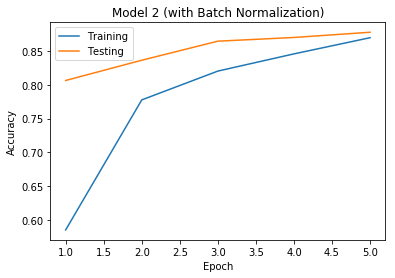

In [179]:
xVal = np.arange(1, 6, 1)
plt.plot(xVal, mode21Hist.acc)
plt.plot(xVal, mode21Hist.val_acc)
plt.title('Model 2 (with Batch Normalization)')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [23]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 26, 26, 64)        256       
__________

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])
tf.global_variables_initializer()
model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 22,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Train on 9000 samples, validate on 1000 samples
Epoch 1/22
9000/9000 [==============================] - 280s 31ms/step - loss: 0.6454 - acc: 0.7647 - top_3_accuracy: 0.9774 - val_loss: 1.3498 - val_acc: 0.7120 - val_top_3_accuracy: 0.9520
Epoch 2/22
9000/9000 [==============================] - 275s 31ms/step - loss: 0.3855 - acc: 0.8651 - top_3_accuracy: 0.9921 - val_loss: 5.6114 - val_acc: 0.3770 - val_top_3_accuracy: 0.6880
Epoch 3/22
9000/9000 [==============================] - 280s 31ms/step - loss: 0.2786 - acc: 0.9021 - top_3_accuracy: 0.9944 - val_loss: 0.4355 - val_acc: 0.8620 - val_top_3_accuracy: 0.9930
Epoch 4/22
9000/9000 [==============================] - 291s 32ms/step - loss: 0.2097 - acc: 0.9250 - top_3_accuracy: 0.9979 - val_loss: 1.2025 - val_acc: 0.7520 - val_top_3_accuracy: 0.9620
Epoch 5/22
9000/9000 [==============================] - 279s 31ms/step - loss: 0.1498 - acc: 0.9454 - top_3_accuracy: 0.9990 - val_loss: 0.3723 - val_acc: 0.8670 - val_top_3_accuracy: 0.99

In [26]:
model.save('test2')
keras.metrics.top_3_accuracy = top_3_accuracy
model = keras.models.load_model('test2', custom_objects= {'metrics':['accuracy', top_3_accuracy]})


Text(0, 0.5, 'Accuracy')

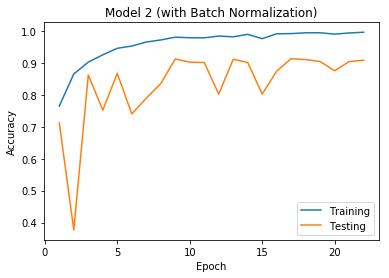

In [27]:
mode21Hist = history_cb
xVal = np.arange(1, 23, 1)
plt.plot(xVal, mode21Hist.acc)
plt.plot(xVal, mode21Hist.val_acc)
plt.title('Model 2 (with Batch Normalization)')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

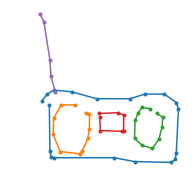

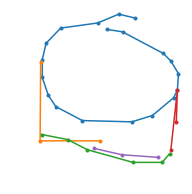

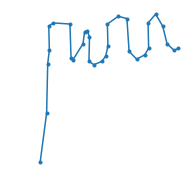

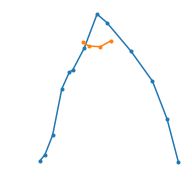

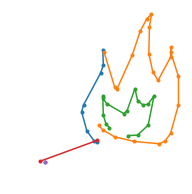

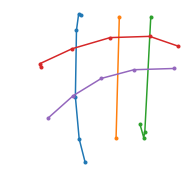

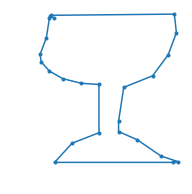

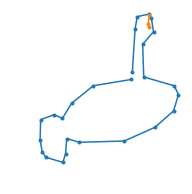

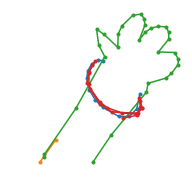

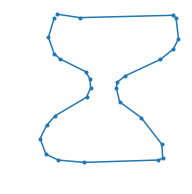

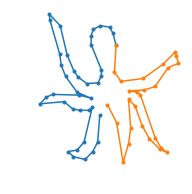

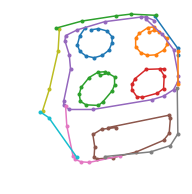

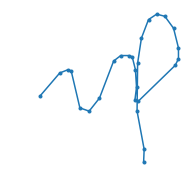

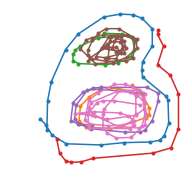

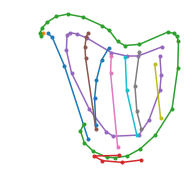

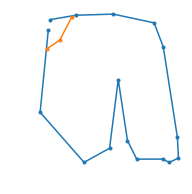

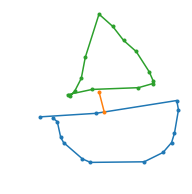

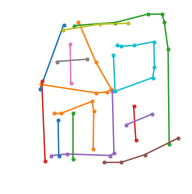

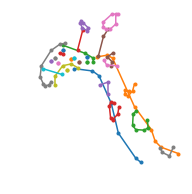

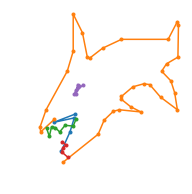

In [180]:
#%% get test set
ttvlist = []
reader = pd.read_csv('input/test_simplified.csv', index_col=['key_id'],
    chunksize=20)

for chunk in reader:
    drawing = [ast.literal_eval(pts) for pts in chunk.drawing.values]
    #labels = chunk.word.tolist()
    for i, example in enumerate(drawing):
        plt.figure(figsize=(6,3))
        for x,y in example:
            plt.subplot(1,2,1)
            plt.plot(x, y, marker='.')
            plt.axis('off')
            #label = labels[i]
            #plt.title(label, fontsize=10)
        plt.gca().invert_yaxis()
        plt.show()
    
    
    #CONVERT IMAGE TO NUMPY ARRAY
    imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    
    testarray = np.array(imagebag.compute())
    testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
    testpreds = model.predict(testarray, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
    ttvlist.append(ttvs)
    break

def save_images(imagebag):
    #SAVE NUMPY ARRAY TO IMAGE
    from matplotlib import cm
    for image in range(len(imagebag.compute())):
        im = Image.fromarray(np.uint8(cm.gist_earth(imagebag.compute()[image])*255))
        #print(im)
        im.save("images/test{0}.png".format(image))

save_images(imagebag)
ttvarray = np.concatenate(ttvlist)

In [181]:
print(testpreds, ttvs)
class_dict = {i:x[:-4].replace(" ", "_") for i, x in enumerate(class_files)}
for key in class_dict:
    class_dict[key] = class_dict[key][class_dict[key].find("\\")+1:]
preds_df = pd.DataFrame({'first': ttvarray[:,0], 'second': ttvarray[:,1], 'third': ttvarray[:,2]})
preds_df = preds_df.replace(class_dict)
preds_df['words'] = preds_df['first'].apply(str) + " " + preds_df['second'].apply(str) + " " + preds_df['third'].apply(str)
preds_df.head()

[[2.82343914e-04 2.20145029e-03 1.58647373e-02 2.75492575e-03
  5.90117590e-04 5.06351469e-03 1.14680140e-03 4.80424060e-04
  5.49550474e-01 1.02253561e-03 3.73829126e-01 4.25830454e-04
  1.43323035e-04 2.25653592e-02 6.13851193e-03 2.29454925e-03
  2.11815815e-04 1.43146329e-02 2.49246892e-04 8.70315649e-04]
 [2.81988122e-08 3.88715969e-04 1.63738672e-02 9.96186282e-05
  1.64804573e-04 7.30285410e-06 8.60287128e-06 7.90446904e-07
  4.44087418e-05 7.45045270e-07 1.82911201e-04 1.81696116e-04
  2.72159639e-07 9.68792856e-01 3.76572507e-06 1.50224811e-03
  8.96458587e-05 2.73017857e-08 1.86841098e-09 1.21576088e-02]
 [2.00544033e-04 1.50314404e-03 4.87415493e-03 2.55468913e-05
  4.44377400e-02 1.21426791e-01 1.03448241e-04 1.78976054e-03
  7.27026165e-02 2.60207144e-05 9.67811793e-03 2.52293306e-04
  2.24065315e-03 7.36754954e-01 1.21985890e-04 5.81816712e-04
  1.81076597e-04 1.19835080e-04 9.40363971e-05 2.88553140e-03]
 [2.97104865e-02 2.20774803e-02 6.23942105e-05 2.50853685e-04
  3.0

,first,second,third,words
0,eyeglasses,foot,piano,eyeglasses foot piano
1,piano,shoe,cruise_ship,piano shoe cruise_ship
2,piano,bat,eyeglasses,piano bat eyeglasses
3,purse,pants,headphones,purse pants headphones
4,grapes,cello,bat,grapes cello bat


In [191]:
sub = pd.read_csv('input/sample_submission.csv', index_col=['key_id'])
sub['word'][:20] = preds_df.words.values
sub.to_csv('subcnn_small.csv')
sub[:20]

,word
key_id,
9000003627287624,eyeglasses foot piano
9000010688666847,piano shoe cruise_ship
9000023642890129,piano bat eyeglasses
9000038588854897,purse pants headphones
9000052667981386,grapes cello bat
9000057427034623,table sweater spider
9000065506980882,spoon foot banana
9000087586309806,cruise_ship shoe foot
9000092580281382,bat grapes river
